### Permutation Feature Importance
2019-10-19

This workbook will explore the concept of randomly shuffling features in a dataset to determine which ones are the most significant for the model's performance. This technique is not new, and quoting directly from Christoph Molnar book on Interpretable Machine Learning "The permutation feature importance measurement was introduced by Breiman for random forests. Based on this idea, Fisher, Rudin, and Dominici proposed a model-agnostic version of the feature importance and called it model reliance." and was introduced by Leo Breiman (2001). Additional information about the technique can be found in the links below.

Supporting Websites:
- Fisher, Aaron, Cynthia Rudin, and Francesca Dominici. “Model Class Reliance: Variable importance measures for any machine learning model class, from the ‘Rashomon’ perspective.” http://arxiv.org/abs/1801.01489 (2018).
- https://christophm.github.io/interpretable-ml-book/feature-importance.html
- https://blogs.technet.microsoft.com/machinelearning/2015/04/14/permutation-feature-importance/
- https://scikit-learn.org/dev/modules/permutation_importance.html

In [1]:
%matplotlib inline

#Load Needed Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')

### Fit A Model

To start, the [Boston housing dataset](https://scikit-learn.org/stable/datasets/index.html#boston-dataset) is used and a Random Forest model is fitted to the training set. The Boston housing dataset contains 13 features used to predict the median value of owner occupied homes in $1000. The Pipeline class is used to scale the features first prior to fitting the model. Once the model is fitted the R^2 and Mean Squared Error of the test set is determined. Finally, print the name of the features in the dataset. 

In [2]:
#initialize the needed variables
d = load_boston()
X = pd.DataFrame(d.data, columns=d.feature_names)
y = pd.Series(d.target, name='y')
seed = 13

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=seed
                                                   )
print('Shape of train set: \t{}'.format(X_train.shape))
print('Shape of test set: \t{}'.format(X_test.shape))

m = Pipeline(steps=[('center',StandardScaler()),
                    ('rf',RandomForestRegressor(
                        n_estimators=100, 
                        random_state=seed))
                   ]
            )
m.fit(X_train, y_train)
print('Test Score R2: \t\t{:.4f}%'.format(m.score(X_test, y_test)))
print('Test Score MSE: \t{:.4f}'.format(mean_squared_error(y_test, m.predict(X_test)) ))

print('\nFeature names in the dataset:\n {}'.format(X_test.columns))

Shape of train set: 	(354, 13)
Shape of test set: 	(152, 13)
Test Score R2: 		0.8630%
Test Score MSE: 	11.3134

Feature names in the dataset:
 Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')


The coefficient of determination (R2) is > 85% and mean squared error value of about $11K on the test set. With these values we will assume the fitted model generalizes well.

### Permutation Feature Function

Here the permutation feature importance function is defined. The function will return a Pandas DataFrame where each row will list the name of the feature shuffled and the difference between the values of the evaluation metrics of the baseline dataset and the dataset with the shuffled feature. 

In [3]:
def find_feature_importance(model, x, y, eval_metric, shuffle_num=10):
    '''
    This function returns a DataFrame with a list of the input x feature names 
    and their estimated importance to the model
    '''
    
    orig = x.copy()
    base = eval_metric(y, model.predict(x))
    output = []
    for f in x.columns:
        x_shuffled = orig.copy()
        for i in range(shuffle_num):
            col = orig.loc[:,f].sample(frac=1.0, random_state=(seed+i)).tolist()
            x_shuffled.loc[:,f] = pd.Series(col,index=x_shuffled.index)
            #the abs() value of diff is used so if eval_metric is a lost 
            #function or scorer function the diff is always a positive value
            d = np.abs(eval_metric(y, model.predict(x_shuffled)) - base)
            output.append( (f, d) )
    return (pd.DataFrame(output, columns=['feature','diff']))


The function is executed using the model fitted earlier with the test dataset, the mean squared error is used as the evaluation metric and each feature are shuffled 50 times. Finally, a bit of the output function is shown.

In [4]:
fi = find_feature_importance(m, X_test, y_test, mean_squared_error, 50)
fi.head()

,feature,diff
0,CRIM,2.259803
1,CRIM,2.356428
2,CRIM,2.843188
3,CRIM,2.223875
4,CRIM,2.225271


Using the DataFrame a boxplot is produced to show which features have the greatest difference / importance.

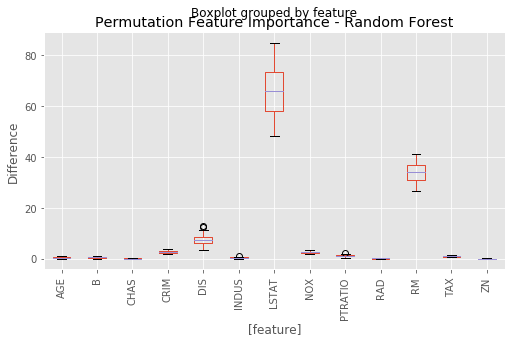

In [10]:
ax = fi.boxplot(by='feature', rot=90, figsize=(8,4.4))
ax.set_ylabel('Difference')
ax.set_title('Permutation Feature Importance - Random Forest')
plt.show()

Additionally, the dataset is grouped by feature and the median computed, then it is sorted in descending order.

In [6]:
ax = fi.groupby('feature').median().sort_values('diff', ascending=False)

The boxplot and sorted DataFrame would suggest that the three most important features in the dataset are LSAT, RM, and DIS with most of the other features having similar values. Looking at the definitions of the features:
- LSTAT = % lower status of the population
- RM = average number of rooms per dwelling
- DIS = weighted distances to five Boston employment centers

These features seem as if they would be very important in determining home prices. 


However, checking the correlation matrix there are a number of features that are highly correlated (>70%) with each other. Therefore, this permutation feature importance method maybe down playing the importance of the highly correlated features. 

In [7]:
X_train.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,1.000000,-0.202162,0.412700,-0.051085,0.439212,-0.184490,0.352927,-0.394076,0.634731,0.589909,0.297771,-0.358492,0.406943
ZN,-0.202162,1.000000,-0.514125,-0.011588,-0.513894,0.344775,-0.560640,0.630939,-0.302015,-0.311293,-0.392691,0.161456,-0.416154
INDUS,0.412700,-0.514125,1.000000,0.000215,0.766860,-0.426592,0.639049,-0.702138,0.586801,0.714491,0.407060,-0.324925,0.618422
CHAS,-0.051085,-0.011588,0.000215,1.000000,-0.008057,0.108690,0.031805,-0.051849,-0.005347,-0.051513,-0.080848,0.066449,-0.077525
NOX,0.439212,-0.513894,0.766860,-0.008057,1.000000,-0.330213,0.736687,-0.776428,0.623659,0.684392,0.240511,-0.367660,0.621945
RM,-0.184490,0.344775,-0.426592,0.108690,-0.330213,1.000000,-0.291318,0.220152,-0.220338,-0.320216,-0.361810,0.146994,-0.610355
AGE,0.352927,-0.560640,0.639049,0.031805,0.736687,-0.291318,1.000000,-0.751857,0.449477,0.505104,0.309452,-0.262097,0.637279
DIS,-0.394076,0.630939,-0.702138,-0.051849,-0.776428,0.220152,-0.751857,1.000000,-0.493252,-0.537066,-0.269662,0.276750,-0.494977
RAD,0.634731,-0.302015,0.586801,-0.005347,0.623659,-0.220338,0.449477,-0.493252,1.000000,0.907015,0.463062,-0.405072,0.455474
TAX,0.589909,-0.311293,0.714491,-0.051513,0.684392,-0.320216,0.505104,-0.537066,0.907015,1.000000,0.465845,-0.405819,0.528328


### Using Another Model

In this section Support Vector model is fitted to the same training data and produced similar test results. The importance function is used again and compared to the first model. 

In [8]:
from sklearn.svm import SVR

m2 = Pipeline(steps=[('center',StandardScaler()),
                    ('rf',SVR( C=25))
                   ]
            )
m2.fit(X_train, y_train)
print('Test Score: \t{:.4f}%'.format(m2.score(X_test, y_test)))
print('Test Score MSE: {:.4f}'.format(mean_squared_error(y_test, m2.predict(X_test)) ))

Test Score: 	0.8566%
Test Score MSE: 11.8417


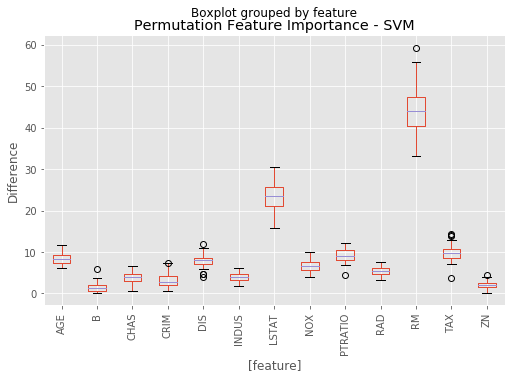

,diff
feature,
RM,43.913996
LSTAT,23.628210
TAX,9.664739
PTRATIO,9.072262
AGE,8.297849
DIS,7.986157
NOX,6.541185
RAD,5.411367
INDUS,4.032275


In [9]:
fi2 = find_feature_importance(m2, X_test, y_test, mean_squared_error, 50)
ax = fi2.boxplot(by='feature', rot=90, figsize=(8,5))
ax.set_ylabel('Difference')
ax.set_title('Permutation Feature Importance - SVM')
plt.show()
fi2.groupby('feature').median().sort_values('diff', ascending=False)

The features RM and LSTAT switch for most and second most important features. The features TAX (TAX = full-value property-tax rate per $10,000) and PTRATIO (PTRATIO = pupil-teacher ratio by town) become the 3rd and 4th important features.

### Conclusion

The permutation feature importance method is an interesting way of determining the importance of a feature in a model regardless of what type of model it is. This method however is model dependent. The features of a dataset important to one model can be very different for another model. Although this can give some interesting insight on the workings of a model.